# VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD
- 앞서 데이터를 로드하고, ```nn.Module``` 을 상속한 모델에 통과시켜, 학습 데이터에 대해 학습을 진행하고, 테스트 데이터에 대해 테스트를 진행했음
- 각 과정에서 무슨 일이 일어났는지 보기 위해서 임의로 print 했음
- 파이토치는 **텐서보드** 와 병합하여 인공신경망의 학습 과정을 시각화할 수 있음
- 여기선 **Fashion MNIST 데이터셋** dp eogks tlrkrghkfmf goqhrpTdma

>**이 튜토리얼에서 배울 것**
>1. 데이터를 적절한 변환으로 읽어오는 방법
>2. TensorBoard 셋업
>3. TensorBoard 작성
>4. TensorBoard 를 이용한 모델 구조 점검
>5. TensorBoard 로 상호작용할 수 있는 시각화 만들기

>**특히 5에서 다룰 것**
>- 학습 데이터를 점검하는 방법
>- 학습이 진행함에 따른 모델의 성능 추적하기
>- 모델이 학습되었을 때 모델 평가하기

- 일단 CIFAR-10 데이터셋을 다뤘을 때와 비슷하게 데이터를 로드하는 코드 작성

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5))]
)

trainset = torchvision.datasets.FashionMNIST("./data",
                                            download=True,
                                            train=True,
                                            transform=transform)
testset = torchvision.datasets.FashionMNIST("./data",
                                            download=True,
                                            train=False,
                                            transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                        shuffle=False, num_workers=2)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5       # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

- 이전 튜토리얼에서 다뤘던 모델과 비슷한 모델로 정의
- 입력 크기가 28x28 에서 32x32 로 바뀜

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- ```optimizer``` 와 ```criterion(loss_function)``` 을 정의

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

---
# 1. TensorBoard setup
- ```torch.utils``` 로부터 ```tensorboard``` 를 임포트한 후 ```SummaryWriter``` 를 정의

In [24]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/fashion_mnist_experiment_1")

---
# 2. Writing to TensorBoard

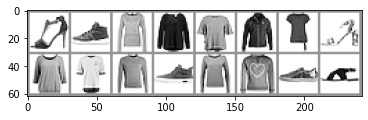

In [25]:
dataiter = iter(trainloader)
imgs, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(imgs)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image("sixteen_fashion_mnist_imgs", img_grid)

---
# 3. Inspect the model using TensorBoard
- 텐서보드의 강점 중 하나는 바로 복잡한 모델 구조를 시각화하는 능력임
- 우리가 만든 모델도 시각화해 보겠음

In [26]:
writer.add_graph(net, imgs)
#writer.close()

---
# 4. Adding a "Projector" to TensorBoard
- **add_embedding** 메서드를 이용하여 고차원 데이터를 저차원 표현으로 시각화할 수 있음

In [27]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][: n], labels[perm][: n]

imgs, labels = select_n_random(trainset.data, trainset.targets)
class_labels = [classes[lab] for lab in labels]

features = imgs.view(-1, 28*28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=imgs.unsqueeze(1))
writer.close()

---
# 5. Tracking model training with TensorBoard
- 이전엔 모델의 성능을 2000 iteration 마다 프린트할 뿐이었음
- 이를 TensorBoard 에 loss 를 계속 누적하여 시각화할 수 있음
- ```plot_classes_preds``` 함수로 이를 구현

In [32]:
def imgs_to_probs(net, imgs):
    output = net(imgs)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, imgs, labels):
    preds, probs = imgs_to_probs(net, imgs)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(imgs[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
        classes[preds[idx]], probs[idx]*100.0, classes[labels[idx]]), 
                     color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

- 이제 모델을 학습하고 매 1000 batch 마다 텐서보드에 결과를 기록할 것
- 이는 **add_scalar** 함수로 진행

In [31]:
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%1000 == 999:
            writer.add_scalar("training loss",
                             running_loss/1000,
                             epoch*len(trainloader) + i)
            writer.add_figure("prediction vs. actuals v2",
                             plot_classes_preds(net, inputs, labels),
                             global_step=epoch*len(trainloader) + i)
            running_loss = 0.0
    print("Finished Training!")

Finished Training!


---
# 6. Assessing trained models with TensorBoard


In [36]:
class_probs = []
class_label = []

with torch.no_grad():
    for data in testloader:
        imgs, labels = data
        output = net(imgs)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        
        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_labels = torch.cat(class_label)

print(test_probs)
print(test_labels)

tensor([[9.7419e-06, 1.9832e-06, 7.6235e-06,  ..., 3.4258e-01, 1.3420e-02,
         5.8827e-01],
        [1.6097e-03, 7.6924e-06, 9.5998e-01,  ..., 5.9867e-08, 1.1307e-03,
         1.6767e-06],
        [8.5612e-07, 9.9999e-01, 1.9163e-09,  ..., 1.8187e-07, 8.6391e-08,
         1.4608e-09],
        ...,
        [4.6716e-03, 2.2612e-07, 1.2643e-03,  ..., 7.3208e-07, 9.7046e-01,
         1.0387e-06],
        [1.4809e-04, 9.6493e-01, 1.0983e-04,  ..., 7.4304e-05, 3.9246e-05,
         4.5612e-05],
        [1.3661e-03, 5.5169e-04, 2.8098e-03,  ..., 2.8881e-01, 2.3958e-01,
         6.1632e-03]])
tensor([9, 2, 1,  ..., 8, 1, 5])


In [38]:
def add_pr_curve_tensorboaed(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                       tensorboard_truth,
                       tensorboard_probs,
                       global_step = global_step)
    writer.close()
    
for i in range(len(classes)):
    add_pr_curve_tensorboaed(i, test_probs, test_labels)